In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import cv2
import os
import wandb
from tqdm import tqdm
from sklearn.model_selection import *
from sklearn.metrics import *
from torch.nn import *
from torch.optim import *
from torch.functional import *
from torchvision import transforms
import random
from PIL import Image

In [2]:
PROJECT_NAME = "Satellite-Image-Classification-V2"
device = torch.device('cuda')

In [3]:
transformation = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(random.randint(0,360)),
        transforms.ColorJitter()
    ]
)

In [4]:
img = cv2.imread('./data/cloudy/train_10021.jpg')

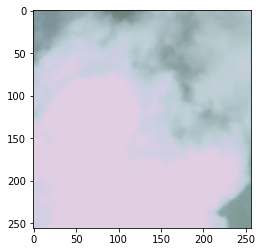

In [5]:
plt.imshow(img)

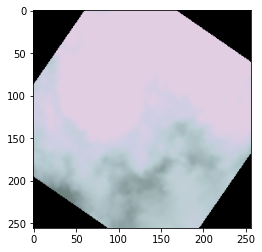

In [6]:
plt.imshow(transformation(Image.fromarray(img)))

In [7]:
def load_data():
    labels = {}
    labels_r = {}
    idx = -1
    data = []
    X = []
    y = []
    for directory in os.listdir('./data/'):
        idx += 1
        labels[directory] = idx
        labels_r[idx] = directory
    for directory in tqdm(os.listdir('./data/')):
        for file in os.listdir('./data/' + directory)[:500]:
            img = cv2.imread('./data/' + directory + '/' + file)
            img = cv2.resize(img,(56,56))
            img = img / 255.0
            data.append([img,labels[directory]])
    np.random.shuffle(data)
    for d in data:
        X.append(d[0])
        y.append(d[1])
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=True)
    X_train = torch.from_numpy(np.array(X_train)).to(device).view(-1,3,56,56).float()
    X_test = torch.from_numpy(np.array(X_test)).to(device).view(-1,3,56,56).float()
    y_train = torch.from_numpy(np.array(y_train)).to(device).float()
    y_test = torch.from_numpy(np.array(y_test)).to(device).float()
    return X_train,X_test,y_train,y_test,data,X,y,labels,labels_r,idx

In [8]:
X_train,X_test,y_train,y_test,data,X,y,labels,labels_r,idx = load_data()

100%|████████████████████████████████████████████| 4/4 [00:00<00:00,  5.72it/s]


In [9]:
torch.save(labels,'./save/labels.pt')
torch.save(labels,'./save/labels.pth')
torch.save(labels_r,'./save/labels_r.pt')
torch.save(labels_r,'./save/labels_r.pth')
torch.save(data,'./save/data.pt')
torch.save(data,'./save/data.pth')
torch.save(X,'./save/X.pt')
torch.save(y,'./save/y.pth')
torch.save(X_train,'./save/X_train.pt')
torch.save(X_test,'./save/X_test.pth')
torch.save(y_train,'./save/y_train.pt')
torch.save(y_test,'./save/y_test.pth')

In [10]:
torch.round(torch.tensor([[[5.5]]]))

tensor([[[6.]]])

In [11]:
def get_loss(model,X,y,criterion):
    preds = model(X)
    loss = criterion(preds,y)
    return loss.item()

In [12]:
def get_accuracy(model,X,y):
    total = 0
    correct = 0
    preds = model(X)
    for pred,y_iter in zip(preds,y):
        pred = torch.round(pred)
        y_iter = torch.round(y_iter)
        if pred == y_iter:
            correct += 1
        total += 1
    return round(correct/total,3)

In [13]:
class Model(Module):
    def __init__(self):
        super().__init__()
        self.relu = ReLU()
        self.max_pool2d = MaxPool2d((2,2))
        self.conv1 = Conv2d(3,16,5)
        self.conv2norm = BatchNorm2d(16)
        self.conv3 = Conv2d(16,32,5)
        self.linear1 = Linear(32*11*11,256)
        self.linear2 = Linear(256,512)
        self.linear3norm = BatchNorm1d(512)
        self.linear4 = Linear(512,256)
        self.linear5 = Linear(256,1)
    
    def forward(self,X):
        preds = self.max_pool2d(self.relu(self.conv1(X)))
        preds = self.conv2norm(preds)
        preds = self.max_pool2d(self.relu(self.conv3(preds)))
        preds = preds.view(-1,32*11*11)
        preds = self.relu(self.linear1(preds))
        preds = self.relu(self.linear2(preds))
        preds = self.linear3norm(preds)
        preds = self.relu(self.linear4(preds))
        preds = self.relu(self.linear5(preds))
        return preds

In [14]:
model = Model().to(device)
criterion = L1Loss()
optimizer = Adam(model.parameters(),lr=0.001)
batch_size = 32
epochs = 100

In [ ]:
wandb.init(project=PROJECT_NAME,name='BaseLine')
for _ in tqdm(range(epochs)):
    for idx in range(0,len(X_train),batch_size):
        X_batch = X_train[idx:idx+batch_size].float()
        y_batch = y_train[idx:idx+batch_size].float()
        preds = model(X_batch.float())
        loss = criterion(preds.float(),y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log({
            "Accuracy":((get_accuracy(model,X_batch,y_batch)+get_accuracy(model,X_test,y_test))/2)*100,
            "Loss":((get_loss(model,X_batch,y_batch,criterion)+get_loss(model,X_test,y_test,criterion))/2)
        })
wandb.finish()

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)
RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd


  0%|                                                  | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to b

In [ ]:
torch.save('./save/model.pt',model)
torch.save('./save/model.pth',model)
torch.save('./save/criterion.pt',criterion)
torch.save('./save/criterion.pth',criterion)
torch.save('./save/optimizer.pt',optimizer)
torch.save('./save/optimizer.pth',optimizer)

In [ ]:
del model,criterion,optimizer

In [ ]:
model = torchvision.models.resnet18(pretrained=True,num_classes=1)
loss = MSELoss()
optimizer = Adam(model.parameters(),lr=0.001)
batch_size = 32
epochs = 100

In [ ]:
wandb.init(project=PROJECT_NAME,name='Pretrianed=True Resenet18')
for _ in tqdm(range(epochs)):
    for idx in range(0,len(X_train),batch_size):
        X_batch = X_train[idx:idx+batch_size].float()
        y_batch = y_train[idx:idx+batch_size].float()
        preds = model(X_batch.float())
        loss = criterion(preds.float(),y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log({
            "Accuracy":((get_accuracy(model,X_batch,y_batch)+get_accuracy(model,X_test,y_test))/2)*100,
            "Loss":((get_loss(model,X_batch,y_batch,criterion)+get_loss(model,X_test,y_test,criterion))/2)
        })
wandb.finish()

In [ ]:
torch.save('./save/model-2.pt',model)
torch.save('./save/model-2.pth',model)
torch.save('./save/criterion-2.pt',criterion)
torch.save('./save/criterion-2.pth',criterion)
torch.save('./save/optimizer-2.pt',optimizer)
torch.save('./save/optimizer-2.pth',optimizer)

In [ ]:
del model,criterionterion,optimizer

In [ ]:
model = torchvision.models.resnet18(pretrained=False,num_classes=1)
loss = MSELoss()
optimizer = Adam(model.parameters(),lr=0.001)
batch_size = 32
epochs = 100

In [ ]:
wandb.init(project=PROJECT_NAME,name='Pretrianed=True Resenet18')
for _ in tqdm(range(epochs)):
    for idx in range(0,len(X_train),batch_size):
        X_batch = X_train[idx:idx+batch_size].float()
        y_batch = y_train[idx:idx+batch_size].float()
        preds = model(X_batch.float())
        loss = criterion(preds.float(),y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log({
            "Accuracy":((get_accuracy(model,X_batch,y_batch)+get_accuracy(model,X_test,y_test))/2)*100,
            "Loss":((get_loss(model,X_batch,y_batch,criterion)+get_loss(model,X_test,y_test,criterion))/2)
        })
wandb.finish()

In [ ]:
torch.save('./save/model-3.pt',model)
torch.save('./save/model-3.pth',model)
torch.save('./save/criterion-3.pt',criterion)
torch.save('./save/criterion-3.pth',criterion)
torch.save('./save/optimizer-3.pt',optimizer)
torch.save('./save/optimizer-3.pth',optimizer)